# Code for fig. S8 of
#### Yeager et al., 2021: An Outsized Role for the Labrador Sea in the Multidecadal Variability of the Atlantic Overturning Circulation, *Science Advances*.

In [26]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import dask
%matplotlib inline

## Create Dask Cluster

In [25]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [27]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [28]:
cluster, client = get_ClusterClient()
cluster.scale(10) 

In [29]:
cluster

In [30]:
def open_POPdataset(x):
    ds = xr.open_dataset(x,decode_times=False)
    attrs=ds.time.attrs.copy()
    ds = ds.assign_coords(time=ds.time.values - 15)
    ds.time.attrs = attrs
    ds = xr.decode_cf(ds)
    return ds

In [31]:
datadir = '/glade/scratch/yeager/YeagerEA_ScienceAdvances_2021/'
f2_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.020001_050012.MOCsig.nc'
f3_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.020001_050012.WMF.nc'
f6_hr = f'{datadir}/wmf.regions.POP_0p1.nc'

ds2_hr = open_POPdataset(f2_hr) 
ds3_hr = open_POPdataset(f3_hr) 
ds6_hr = xr.open_dataset(f6_hr).isel(nlon=slice(512,1233)).isel(nlat=slice(1627,2283))

In [32]:
# Add additional regions to WMF datasets
ds3_hr1 = ds3_hr.isel(wmf_region=[1,2,3,5,6]).sum('wmf_region')
ds3_hr1 = ds3_hr1.assign_coords({'wmf_region':'ALL minus LAB (7)'})
ds3_hr2 = ds3_hr.isel(wmf_region=[1,2,3]).sum('wmf_region')
ds3_hr2 = ds3_hr2.assign_coords({'wmf_region':'IRM+SPG (8)'})
ds3_hr3 = ds3_hr.isel(wmf_region=[1,4]).sum('wmf_region')
ds3_hr3 = ds3_hr3.assign_coords({'wmf_region':'LAB+SPG-west (9)'})
ds3_hr4 = ds3_hr.isel(wmf_region=[2,3]).sum('wmf_region')
ds3_hr4 = ds3_hr4.assign_coords({'wmf_region':'IRM+SPG-east (10)'})
ds3_hr = xr.concat([ds3_hr,ds3_hr1,ds3_hr2,ds3_hr3,ds3_hr4],dim='wmf_region')

## Compute Anomalies and Std Dev (years 200-500)

In [33]:
ds2_hr_ann = ds2_hr.groupby('time.year').mean('time')
ds3_hr_ann = ds3_hr.groupby('time.year').mean('time')

ds2_hr_ann=ds2_hr_ann.rename({'year':'time'}).sel(time=slice(200,500))
ds3_hr_ann=ds3_hr_ann.rename({'year':'time'}).sel(time=slice(200,500))

In [34]:
# Annual Anomalies
ds2_hr_mean = ds2_hr_ann.mean('time')
ds2_hr_annanom = ds2_hr_ann - ds2_hr_mean
ds3_hr_mean = ds3_hr_ann.mean('time')
ds3_hr_annanom = ds3_hr_ann - ds3_hr_mean

In [35]:
# load, if using dask
ds2_hr_annanom = ds2_hr_annanom.load()
ds3_hr_annanom = ds3_hr_annanom.load()

In [36]:
# Annual Detrended Anomalies
ds2_hr_annanom_dt = xr.apply_ufunc(signal.detrend, ds2_hr_annanom.fillna(0), kwargs={'axis': 0}).where(ds2_hr_annanom.notnull())
ds3_hr_annanom_dt = xr.apply_ufunc(signal.detrend, ds3_hr_annanom.fillna(0), kwargs={'axis': 0}).where(ds3_hr_annanom.notnull())

## Temporal Filtering

In [37]:
# 10-year butterworth low-pass filter
fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
nyquist = fs / 2          # 0.5 times the sampling frequency
cutoff = fs/10            # 10-year cutoff frequency
cutoff = cutoff/nyquist   # as fraction of nyquist  
print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
filtb, filta = signal.butter(4, cutoff, 'lowpass')


cutoff=  10.0  years


#### Now Apply Filter Using Xarray apply_ufunc

In [38]:
# Low-Pass (lp) anomalies:
ds2_hr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds2_hr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds2_hr_annanom_dt.notnull())
ds3_hr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds3_hr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds3_hr_annanom_dt.notnull())

In [39]:
# Detrended, filtered Std Dev:
ds2_hr_anndtstd = ds2_hr_annanom_dt.std('time')
ds2_hr_lpdtstd = ds2_hr_lpanom_dt.std('time')
ds3_hr_anndtstd = ds3_hr_annanom_dt.std('time')
ds3_hr_lpdtstd = ds3_hr_lpanom_dt.std('time')

In [40]:
# First, create low-pass-filtered, detrended AMOC that includes the mean
ds2_hr_lpann_dt = ds2_hr_lpanom_dt + ds2_hr_mean
ds3_hr_lpann_dt = ds3_hr_lpanom_dt + ds3_hr_mean

## Lag Correlation Analysis

In [41]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backward. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        #x   = x.shift(time = -lagx).dropna(dim='time')
        if lagx>0: x = x.shift(time = -lagx).isel(time=slice(0,-lagx))
        if lagx<0: x = x.shift(time = -lagx).isel(time=slice(-lagx,None))

        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        #y   = y.shift(time = -lagy).dropna(dim='time')
        if lagy>0: y = y.shift(time = -lagy).isel(time=slice(0,-lagy))
        if lagy<0: y = y.shift(time = -lagy).isel(time=slice(-lagy,None))
        x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    #cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    cov   = ((x - xmean) * (y - ymean)).mean(axis=0)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #6.5. Compute effective degrees of freedom taking into account autocorrelation
    xp1 = x.shift(time=-1).isel(time=slice(0,-1))
    xtmp,xp1 = xr.align(x,xp1)
    autocorrx = xr.corr(xtmp,xp1,dim='time')
    yp1 = y.shift(time=-1).isel(time=slice(0,-1))
    ytmp,yp1 = xr.align(y,yp1)
    autocorry = xr.corr(ytmp,yp1,dim='time')
    neff = n*(1-autocorrx*autocorry)/(1+autocorrx*autocorry)

    #7. Compute P-value and standard error
    #Compute t-statistics
    #tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    tstats = cor*np.sqrt(neff-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats

    from scipy.stats import t
    #pval   = t.sf(tstats, neff-2)*2
    pval = 2.*(1-t.cdf(np.abs(slope/stderr),neff-2))
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)
    
    #8. Combine all stats into single output xarray
    stat = xr.DataArray(['covariance','correlation','slope','intercept','pval','stderr'],dims="stat",name="stat")
    xrout = xr.concat([cov,cor,slope,intercept,pval,stderr],dim=stat)

    return xrout

In [42]:
def concat_regressions(x, y, lagyrange):
    reglist = []
    lazy_results = []
    lag = xr.DataArray([i for i in lagyrange],dims='lag',name='lag')
    for i in lagyrange:
        lazy_result = dask.delayed(lag_linregress_3D)(x,y,lagy=i)
        lazy_results.append(lazy_result)
    z_arr = dask.compute(*lazy_results)
    for i in range(0,np.shape(lagrange)[0]):
        z = z_arr[i]
        z.name = y.name + '_regr_'+x.name
        reglist.append(z)
    return xr.concat(reglist,dim=lag)

In [43]:
def lag_composite_3D(x, y,lagy=0):
    """
    Input: Two xr.Datarrays the first of which, x, is a masked 1D index that has dimensions
    of time. The other, y, could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). Both x and y are assumed to be anomaly time series.
    Output: Composite anomalies of y corresponding to times where x is valid. 
    Lag composites are obtained by shifting y by lagy.
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)

    #3. Add lag information if any, and shift the data accordingly
    if lagy!=0:
        #y   = y.shift(time = -lagy).dropna(dim='time')
        if lagy>0: y = y.shift(time = -lagy).isel(time=slice(0,-lagy))
        if lagy<0: y = y.shift(time = -lagy).isel(time=slice(-lagy,None))
        x,y = xr.align(x,y)

    #4. Compute data length, mean and standard deviation along time axis: 
    ysub = y.where(~np.isnan(x))
    #ysub1 = y.where(np.isnan(x))
    ymean = ysub.mean(axis=0)
    
    from scipy import stats
    tstat,pval = stats.ttest_1samp(ysub,0.,nan_policy='omit')
    pval   = xr.DataArray(pval, dims=ymean.dims, coords=ymean.coords)
    
    #8. Combine all stats into single output xarray
    stat = xr.DataArray(['mean','pval'],dims="stat",name="stat")
    xrout = xr.concat([ymean,pval],dim=stat)

    return xrout

In [44]:
def concat_composites(x, y, lagyrange):
    complist = []
    lazy_results = []
    lag = xr.DataArray([i for i in lagyrange],dims='lag',name='lag')
    for i in lagyrange:
        lazy_result = dask.delayed(lag_composite_3D)(x,y,lagy=i)
        lazy_results.append(lazy_result)
    z_arr = dask.compute(*lazy_results)
    for i in range(0,np.shape(lagrange)[0]):
        z = z_arr[i]
        z.name = y.name + '_comp_'+x.name
        complist.append(z)
    return xr.concat(complist,dim=lag)

In [45]:
# First compute needed indices:
hr_dlsw = [37.0625,37.125]
hr_mocmax = ds2_hr_lpann_dt.MOCsig.isel(transport_reg=1).isel(moc_comp=0).sel(lat_aux_grid=55,method='nearest').max(dim='moc_s')
hr_mocdwbc = ds2_hr_lpann_dt.MOCsig.isel(transport_reg=1).isel(moc_comp=0).sel(lat_aux_grid=55,method='nearest').sel(moc_s=slice(hr_dlsw[0],hr_dlsw[1])).mean('moc_s')

## Compute Lag Composites on chosen index

In [46]:
# Define lag range & normalized index
lagrange = range(-35,36,1)
hr_index = hr_mocdwbc
hr_index = hr_index - hr_index.mean('time')
hr_std = hr_index.std('time')
hr_index = hr_index/hr_std
hr_index_pos = hr_index.where(hr_index>(hr_std*1))
hr_index_neg = hr_index.where(hr_index<(hr_std*-1))

In [47]:
%%time
# Compute lag regressions:  MOCsig
workhr = ds2_hr_lpanom_dt.MOCsig.isel(transport_reg=1).isel(moc_comp=0).sel(lat_aux_grid=55,method='nearest')
MOCsigcomp_hr_pos = concat_composites(hr_index_pos,workhr,lagrange)
MOCsigcomp_hr_neg = concat_composites(hr_index_neg,workhr,lagrange)

CPU times: user 711 ms, sys: 60.3 ms, total: 771 ms
Wall time: 7.2 s


In [48]:
%%time
# Compute lag composites:  WMT/WMF
WMTcomp_hr_pos = concat_composites(hr_index_pos,ds3_hr_lpanom_dt.WMT,lagrange)
WMTcomp_hr_neg = concat_composites(hr_index_neg,ds3_hr_lpanom_dt.WMT,lagrange)
WMFcomp_hr_pos = concat_composites(hr_index_pos,ds3_hr_lpanom_dt.WMF,lagrange)
WMFcomp_hr_neg = concat_composites(hr_index_neg,ds3_hr_lpanom_dt.WMF,lagrange)

CPU times: user 1.39 s, sys: 390 ms, total: 1.78 s
Wall time: 2.53 s


# fig S8

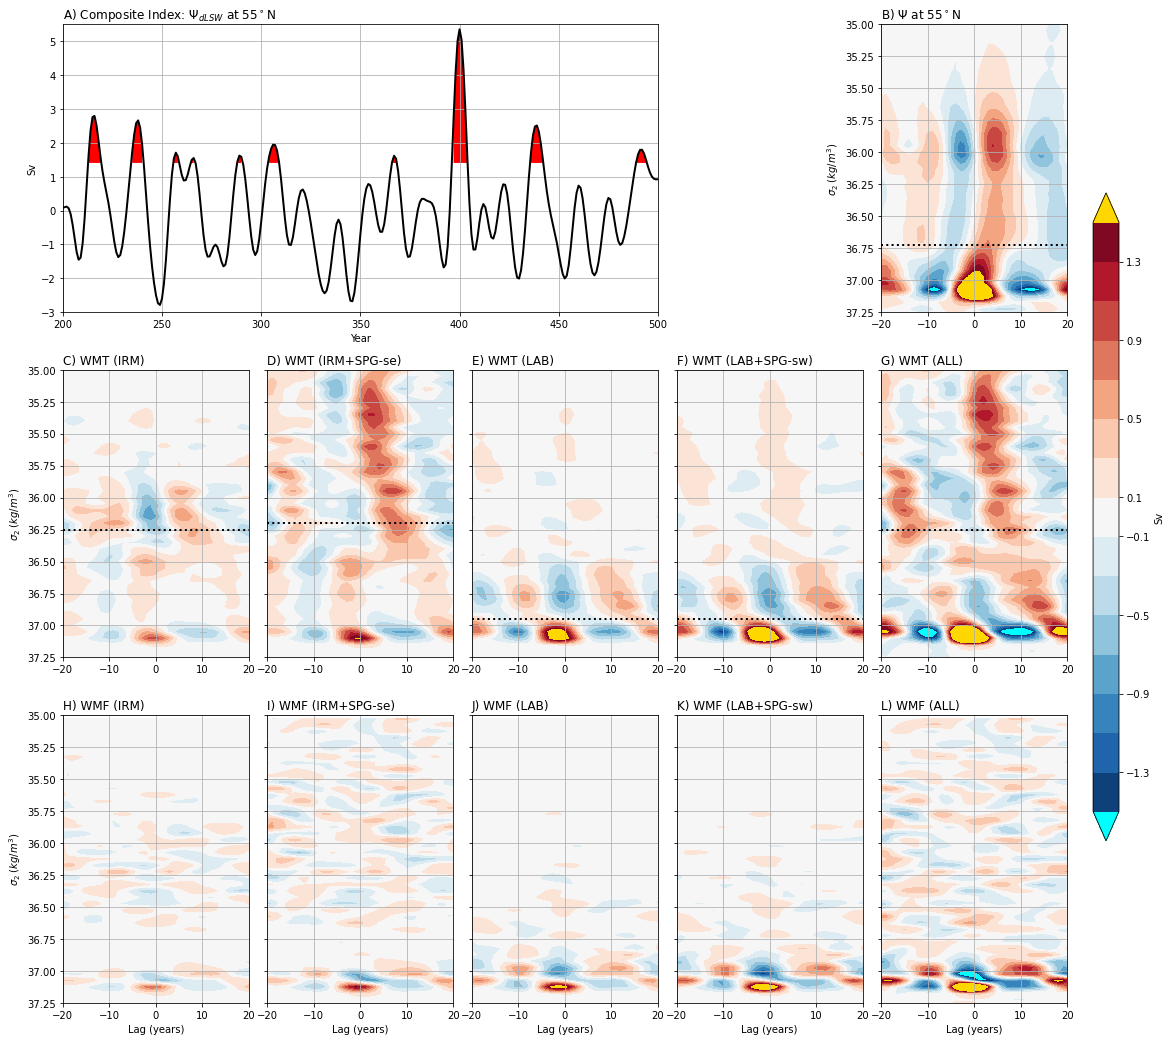

In [49]:
# Year 200-500 hovmuller plots
fig = plt.figure(figsize=(18, 18))
spec = fig.add_gridspec(ncols=5, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec[0, 4])
ax2 = fig.add_subplot(spec[0, 0:3])

ax4 = fig.add_subplot(spec[1, 0])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[1, 3])
ax7 = fig.add_subplot(spec[1, 2])
ax8 = fig.add_subplot(spec[1, 4])

ax9 = fig.add_subplot(spec[2, 0])
ax10 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[2, 3])
ax12 = fig.add_subplot(spec[2, 2])
ax13 = fig.add_subplot(spec[2, 4])

mnlevs = np.arange(0,17,1)*4. - 4.
#colmap = copy.copy(plt.cm.RdYlBu_r)
colmap = copy.copy(plt.cm.RdBu_r)
#colmap = copy.copy(plt.cm.seismic)
overclr = 'gold'
#overclr = 'white'
underclr = 'cyan'
faceclr = 'lightsteelblue'
#rlevs = np.arange(0,16,1)*0.4 - 3
rlevs = np.arange(0,16,1)*0.2 - 1.5
#baselevs = np.array([-6,-5,-4,-3,-2,-1,-0.5,0.5,1,2,3,4,5,6])
#baseticks = np.array([-4,-2,2,4])
fontsize=12

ylat = 45
xlim=[-20,20]
ylim=[37.25,35]
ylim1=[37.6,36.0]
ylim2=[-1.,1]
yticks2 = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
fsize=12
lw = 0.5
siglvl = 0.05


simstr = 'HR'

work2 = ds2_hr_mean.MOCsig.isel(transport_reg=1).isel(moc_comp=0).sel(lat_aux_grid=ylat,method='nearest')
work3 = ds3_hr_mean.WMT

ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax1.set_title(r'B) $\Psi$ at 55$^\circ$N', fontdict={'size':fsize}, loc='left')
#rlevs = baselevs*0.25
#rticks = baseticks*0.25
cntr1 = ax1.contourf(MOCsigcomp_hr_pos.lag, MOCsigcomp_hr_pos.moc_s,MOCsigcomp_hr_pos.sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
#cntr1a = ax1.contour(MOCsigcomp_hr_pos.lag, MOCsigcomp_hr_pos.moc_s,MOCsigcomp_hr_pos.sel(stat='pval').T,levels=[siglvl],colors='k')
cntr1.cmap.set_under(underclr)
cntr1.cmap.set_over(overclr)
#tmp1 = hrreg_moc45.where(hrreg_moc45.sel(stat='pval') > siglvl)
#cntr1a = ax1.contour(hrreg_moc45.lag, hrreg_moc45.moc_s,hrreg_moc45.sel(stat='pval').T, levels=[siglvl],color='k')
sig2max1 = work2.moc_s[work2.argmax(axis=0)]
plt1 = ax1.plot(xlim, [sig2max1,sig2max1],color='k',linewidth=2,linestyle='dotted')
ax1.grid()

hrmean = hr_mocdwbc.mean('time')
hrdwbcanom = hr_mocdwbc - hr_mocdwbc.mean('time')
hr_std = hr_mocdwbc.std('time')
sig = 1
legloc = 'upper left'
ax2.set_ylabel('Sv')
ax2.set_xlabel('Year')
#ax2.set_ylim([17,23])
ax2.set_ylim([-3,5.5])
ax2.set_xlim([200,500])
stat_str = ' ($\mu$={:4.2f} Sv, $\sigma$={:3.2f} Sv)'.format(hrmean.values,hr_std.values)
ax2.set_title(r'A) Composite Index: $\Psi_{dLSW}$ at 55$^\circ$N', fontdict={'size':fsize},loc='left')
ax2.plot(hrdwbcanom.time, hrdwbcanom,linewidth=2,color='k')
ax2.plot([200,500], [hrmean,hrmean],linewidth=1,color='k')
sighi = (hr_std)*sig
siglo =-(hr_std)*sig
ax2.fill_between(hrdwbcanom.time,sighi,hrdwbcanom,where=hrdwbcanom >= sighi,facecolor='red')
#ax2.fill_between(hr_mocmax.time,siglo,hr_mocmax,where=hr_mocmax <= siglo,facecolor='blue')
ax2.grid()

#ax4.set_xlabel('Lag (years)')
ax4.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax4.set_ylim(ylim)
ax4.set_xlim(xlim)
ax4.set_title(r'C) WMT (IRM)', fontdict={'size':fsize}, loc='left')
cntr4 = ax4.contourf(WMTcomp_hr_pos.lag,WMTcomp_hr_pos.sigma_wmt,WMTcomp_hr_pos.isel(wmf_region=3).sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
cntr4.cmap.set_under(underclr)
cntr4.cmap.set_over(overclr)
sig2max4 = work3.sigma_wmt[work3.isel(wmf_region=3).argmax(axis=0)]
plt4 = ax4.plot(xlim, [sig2max4,sig2max4],color='k',linewidth=2,linestyle='dotted')
ax4.grid()

#ax5.set_xlabel('Lag (years)')
ax5.set_ylim(ylim)
ax5.set_xlim(xlim)
ax5.set_title(r'D) WMT (IRM+SPG-se)', fontdict={'size':fsize}, loc='left')
cntr5 = ax5.contourf(WMTcomp_hr_pos.lag,WMTcomp_hr_pos.sigma_wmt,WMTcomp_hr_pos.isel(wmf_region=10).sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
cntr5.cmap.set_under(underclr)
cntr5.cmap.set_over(overclr)
sig2max5 = work3.sigma_wmt[work3.isel(wmf_region=10).argmax(axis=0)]
plt5 = ax5.plot(xlim, [sig2max5,sig2max5],color='k',linewidth=2,linestyle='dotted')
ax5.set_yticklabels([])
ax5.grid()

#ax7.set_xlabel('Lag (years)')
ax7.set_ylim(ylim)
ax7.set_xlim(xlim)
ax7.set_title(r'E) WMT (LAB)', fontdict={'size':fsize}, loc='left')
cntr7 = ax7.contourf(WMTcomp_hr_pos.lag,WMTcomp_hr_pos.sigma_wmt,WMTcomp_hr_pos.isel(wmf_region=4).sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
cntr7.cmap.set_under(underclr)
cntr7.cmap.set_over(overclr)
sig2max7 = work3.sigma_wmt[work3.isel(wmf_region=4).argmax(axis=0)]
plt7 = ax7.plot(xlim, [sig2max7,sig2max7],color='k',linewidth=2,linestyle='dotted')
ax7.set_yticklabels([])
ax7.grid()

#ax6.set_xlabel('Lag (years)')
ax6.set_ylim(ylim)
ax6.set_xlim(xlim)
ax6.set_title(r'F) WMT (LAB+SPG-sw)', fontdict={'size':fsize}, loc='left')
cntr6 = ax6.contourf(WMTcomp_hr_pos.lag,WMTcomp_hr_pos.sigma_wmt,WMTcomp_hr_pos.isel(wmf_region=9).sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
cntr6.cmap.set_under(underclr)
cntr6.cmap.set_over(overclr)
sig2max6 = work3.sigma_wmt[work3.isel(wmf_region=9).argmax(axis=0)]
plt6 = ax6.plot(xlim, [sig2max6,sig2max6],color='k',linewidth=2,linestyle='dotted')
ax6.set_yticklabels([])
ax6.grid()


#ax8.set_xlabel('Lag (years)')
ax8.set_ylim(ylim)
ax8.set_xlim(xlim)
ax8.set_title(r'G) WMT (ALL)', fontdict={'size':fsize}, loc='left')
cntr8 = ax8.contourf(WMTcomp_hr_pos.lag,WMTcomp_hr_pos.sigma_wmt,WMTcomp_hr_pos.isel(wmf_region=0).sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
cntr8.cmap.set_under(underclr)
cntr8.cmap.set_over(overclr)
sig2max8 = work3.sigma_wmt[work3.isel(wmf_region=0).argmax(axis=0)]
plt8 = ax8.plot(xlim, [sig2max8,sig2max8],color='k',linewidth=2,linestyle='dotted')
ax8.set_yticklabels([])
ax8.grid()

ax9.set_xlabel('Lag (years)')
ax9.set_ylabel(r'$\sigma_2\; (kg/m^{3})$')
ax9.set_ylim(ylim)
ax9.set_xlim(xlim)
ax9.set_title(r'H) WMF (IRM)', fontdict={'size':fsize}, loc='left')
cntr9 = ax9.contourf(WMFcomp_hr_pos.lag,WMFcomp_hr_pos.sigma_wmf,WMFcomp_hr_pos.isel(wmf_region=3).sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
cntr9.cmap.set_under(underclr)
cntr9.cmap.set_over(overclr)
ax9.grid()

ax10.set_xlabel('Lag (years)')
ax10.set_ylim(ylim)
ax10.set_xlim(xlim)
ax10.set_title(r'I) WMF (IRM+SPG-se)', fontdict={'size':fsize}, loc='left')
cntr10 = ax10.contourf(WMFcomp_hr_pos.lag,WMFcomp_hr_pos.sigma_wmf,WMFcomp_hr_pos.isel(wmf_region=10).sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
cntr10.cmap.set_under(underclr)
cntr10.cmap.set_over(overclr)
ax10.set_yticklabels([])
ax10.grid()

ax12.set_xlabel('Lag (years)')
ax12.set_ylim(ylim)
ax12.set_xlim(xlim)
ax12.set_title(r'J) WMF (LAB)', fontdict={'size':fsize}, loc='left')
cntr12 = ax12.contourf(WMFcomp_hr_pos.lag,WMFcomp_hr_pos.sigma_wmf,WMFcomp_hr_pos.isel(wmf_region=4).sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
cntr12.cmap.set_under(underclr)
cntr12.cmap.set_over(overclr)
ax12.set_yticklabels([])
ax12.grid()

ax11.set_xlabel('Lag (years)')
ax11.set_ylim(ylim)
ax11.set_xlim(xlim)
ax11.set_title(r'K) WMF (LAB+SPG-sw)', fontdict={'size':fsize}, loc='left')
cntr11 = ax11.contourf(WMFcomp_hr_pos.lag,WMFcomp_hr_pos.sigma_wmf,WMFcomp_hr_pos.isel(wmf_region=9).sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
cntr11.cmap.set_under(underclr)
cntr11.cmap.set_over(overclr)
ax11.set_yticklabels([])
ax11.grid()

ax13.set_xlabel('Lag (years)')
ax13.set_ylim(ylim)
ax13.set_xlim(xlim)
ax13.set_title(r'L) WMF (ALL)', fontdict={'size':fsize}, loc='left')
cntr13 = ax13.contourf(WMFcomp_hr_pos.lag,WMFcomp_hr_pos.sigma_wmf,WMFcomp_hr_pos.isel(wmf_region=0).sel(stat='mean').T,cmap=colmap,extend='both',levels=rlevs)
cntr13.cmap.set_under(underclr)
cntr13.cmap.set_over(overclr)
ax13.set_yticklabels([])
ax13.grid()


fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1, cax=cbar_ax, label='Sv',
             ticks=[-1.3,-0.9,-0.5,-0.1,0.1,0.5,0.9,1.3])
             #ticks=rticks)

plt.savefig('fig_S8.pdf')